In [25]:
%pip install statsmodels
# Import necessary libraries
import pandas as pd  # For data manipulation and handling
import statsmodels.formula.api as smf  # For statistical modeling
from datetime import datetime
import numpy as np

#Laden des merged_data.csv
merged_data_csv = "/workspaces/DS_ML_Gr_1.5/2_BaselineModel/merged_data_new.csv"
df_merged_data = pd.read_csv(merged_data_csv)

df = pd.DataFrame(df_merged_data)

# Fehlende Werte (NaN) durch 0 ersetzen
df_merged_data = df_merged_data.replace(to_replace=r'NaN', value='0', regex=True)
df_merged_data = df_merged_data.replace(to_replace=r'^-$', value='0', regex=True)
df_filled = df_merged_data.fillna(0)
df=df_filled
#Bennenung der Warengruppne für dataframe Namen
warengruppe_namen = {
    1: 'Brot',
    2: 'Broetchen',
    3: 'Crossaint',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}

# Ursprüngliche DataFrames filtern nach Warengruppe
warengruppe_dataframes = {}
for i, name in warengruppe_namen.items():
    var_name = f"df_{name}_W{i}"  # Name erstellen nach: df_Brot_W1
    warengruppe_dataframes[var_name] = df_filled[
        (df_filled['Warengruppe'] == i) &
        (df_filled['Datum'] <= '2018-07-31')
    ]

# Daten bis 2019-07-31 unabhängig der Warengruppe hinzufügen
new_data = df_filled[
    (df_filled['Datum'] > '2018-07-31') &
    (df_filled['Datum'] <= '2019-08-31')
]

for var_name, df in warengruppe_dataframes.items():
    updated_df = pd.concat([df, new_data], ignore_index=True)
    globals()[var_name] = updated_df

data=df_Saisonbrot_W6
print(data.tail())    

# Fit a linear regression model
# - 'Umsatz' is the dependent variable (target) we aim to predict.
# - 'Warengruppe' represents the size of neighboring lots (continuous feature). (Stimmt zwar nicht, aber erstmal so als Beispiel)
# - 'C(Wochentag)' treats the 'Wochentag' feature as a categorical variable.
mod = smf.ols('Umsatz ~ Warengruppe+C(Wochentag)', data=data).fit()

# Output the summary of the fitted model
# The summary includes key metrics such as R-squared, coefficients, and p-values.
print(mod.summary())


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
          Datum  Inflationsrate  Heimspiel  Weihnachtsmarkt  Markt  \
652  2019-07-27             0.0          1                0      0   
653  2019-07-28             0.0          0                0      0   
654  2019-07-29             0.0          0                0      0   
655  2019-07-30             0.0          0                0      0   
656  2019-07-31             0.0          0                0      0   

    Faehrverkaehr  Kreuzfahrverkehr  Temperatur  Monat Jahreszeit  ...  \
652             0               0.0     23.5375    7.0     Sommer  ...   
653             0               0.0     23.3500    7.0     Sommer  ...   
654             0               0.0     25.2500    7.0     Sommer  ...   
655             0               0.0     20.7375    7.0     Sommer  ...   
656             0               

In [26]:
# Import necessary libraries
import pandas as pd  # Data manipulation and handling
import statsmodels.api as sm  # Building and summarizing regression models
from sklearn.preprocessing import StandardScaler  # Scaling features for regression
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets
import matplotlib.pyplot as plt  # Visualization library
import seaborn as sns  # Advanced data visualizations

# Load the dataset 
data=data

# Display the first few rows of the dataset for inspection
print(data.head())

# Select features and target variable
# Features include the different Warengruppen, Monday y/n
features = ['Inflationsrate','Heimspiel','Weihnachtsmarkt', 'Markt','Temperatur','Monat' ,'Frühling','Sommer','Herbst','Winter','Temp_warm','Temp_cold','Temp_average', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Schulferien','Semesterferien','Feiertage','Niederschlag', 'Schneehoehe','Sonnenschein','KielerWoche']
X = data[features] #target variable: Umsatz
y=data['Umsatz']

# Scale the feature data to standardize the range
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'

# Convert to datetime if not already
data['Datum'] = pd.to_datetime(data['Datum'])
# Split the data based on the date thresholds
train_data = data[data['Datum'] <= train_end_date]
validation_data = data[(data['Datum'] > train_end_date) & (data['Datum'] <= validation_end_date)]
test_data = data[data['Datum'] > validation_end_date]

X_train = train_data[features]
y_train = train_data['Umsatz']
X_test=X_validation = validation_data[features]
y_test=y_validation = validation_data['Umsatz']
#X_test = test_data[features] #erstmal so, da die gewünschten daten, keine Daten für test Daten übrig lassen
#y_test = test_data['Umsatz']




# Add a constant term to the training data for the regression intercept
X_train = sm.add_constant(X_train)

# Train the linear regression model using Statsmodels
model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()

# Print the summary of the regression model
# Includes metrics like R-squared, coefficients, and p-values for each feature
print(model.summary())

# Make predictions on the test set
X_test = sm.add_constant(X_test)  # Add constant to test set for predictions
print(X_test)
predictions = model.predict(X_test.astype(float))
print("Predictions for test data:", predictions)

# Calculate Mean Absolute Percentage Error (MAPE) for error evaluation
mape = (abs((y_test - predictions) / y_test).mean()) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Scatter plot: Actual vs. Predicted Umsatz
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color="red")
plt.xlabel("Actual Umsatz")
plt.ylabel("Predicted Umsatz")
plt.title("Actual vs. Predicted Umsatz")
plt.show()

# Calculate residuals (differences between actual and predicted Umsätze)
residuals = y_test - predictions

# Residual plot: Predicted Umsätze vs. Residuals
plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.7, color="green")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Umsätze")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Histogram of residuals to check normality
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color="purple")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Create a DataFrame of model coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + features,
    'Coefficient': model.params
})

# Bar plot of feature coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette="Blues_d")
plt.title("Feature Coefficients")
plt.xlabel("Coefficients")
plt.ylabel("Features")
plt.show()

        Datum  Inflationsrate  Heimspiel  Weihnachtsmarkt  Markt  \
0  2013-10-24            1.53          0                0      0   
1  2013-10-25            1.53          0                0      0   
2  2013-10-26            1.53          0                0      0   
3  2013-10-27            1.53          0                0      0   
4  2013-10-29            1.53          0                0      0   

  Faehrverkaehr  Kreuzfahrverkehr  Temperatur  Monat Jahreszeit  ...  \
0     1.576.718           419.447     12.6875   10.0     Herbst  ...   
1     1.576.718           419.447     11.8875   10.0     Herbst  ...   
2     1.576.718           419.447     16.7750   10.0     Herbst  ...   
3     1.576.718           419.447     14.9875   10.0     Herbst  ...   
4     1.576.718           419.447     10.7750   10.0     Herbst  ...   

   Feiertage  Sonnenaufgang  Sonnenuntergang  Tageslaenge  Niederschlag  \
0        0.0        8:06:32         18:00:44     09:54:12           0.1   
1       

     Inflationsrate  Heimspiel  Weihnachtsmarkt  Markt  Temperatur  Monat  \
236            1.47          0                0      0      8.1000   10.0   
237            1.47          0                0      0     12.9750   11.0   
238            1.47          0                0      0     11.6875   11.0   
239            1.47          0                0      0      9.4375   11.0   
240            1.47          0                0      0     10.2625   11.0   
241            1.47          1                0      0      9.8000   11.0   
242            1.47          0                0      0      8.2125   11.0   
243            1.47          0                0      0      6.7875   11.0   
244            1.47          0                0      0      8.6250   11.0   
245            1.47          0                0      0      8.5500   11.0   
246            1.47          0                0      0      7.5375   11.0   
247            1.47          0                0      0      5.2375   11.0   

ValueError: shapes (56,27) and (28,) not aligned: 27 (dim 1) != 28 (dim 0)

Predictions for test data: [31.98796081 32.89816396 38.16378331 36.81499445 41.95087953]
Mean Absolute Error (MAE): 16.85
Mean Squared Error (MSE): 504.27
Mean Absolute Percentage Error (MAPE): 34.74%


/tmp/ipykernel_36440/2220285916.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color="red")


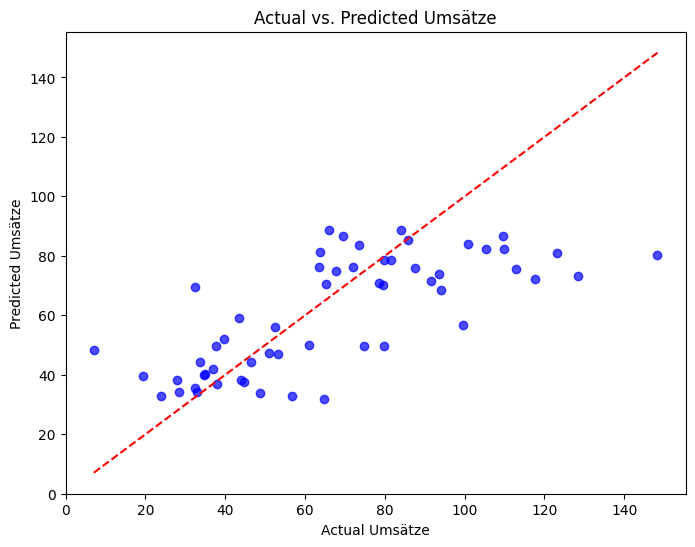

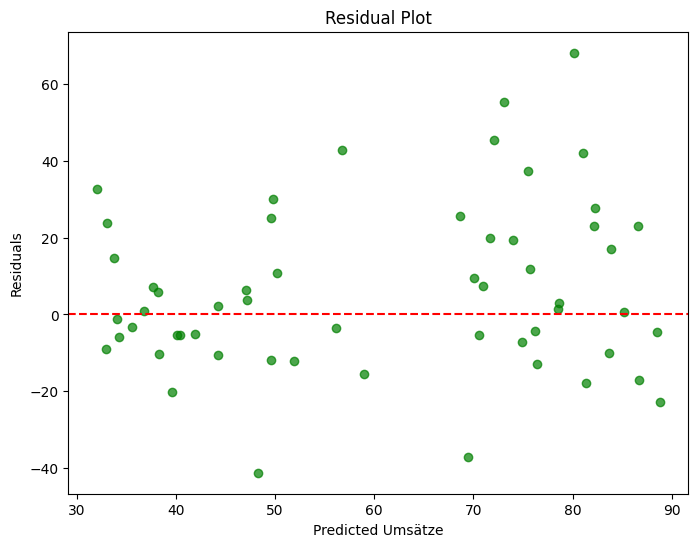

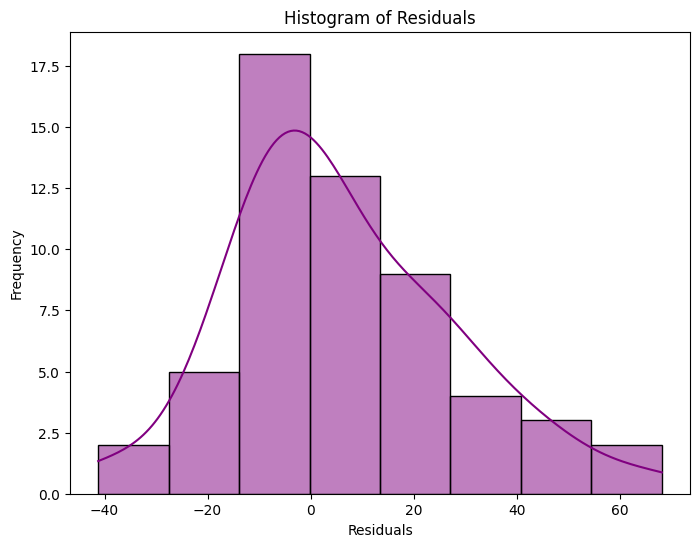

/tmp/ipykernel_36440/2220285916.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette="Blues_d")


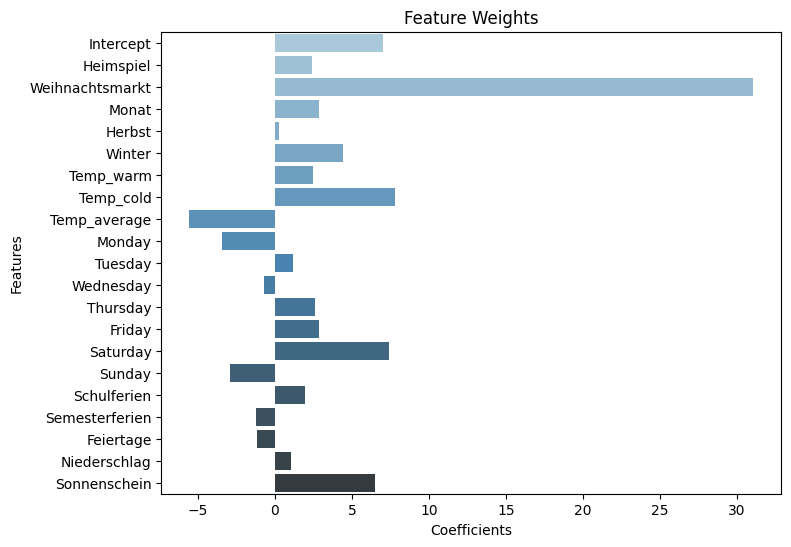

In [24]:
# Import necessary libraries
from sklearn.linear_model import SGDRegressor  # Stochastic Gradient Descent Regressor
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluation metrics
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Advanced visualizations
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets

# Load the dataset

data = data

# Select features and target variable
# Features include 'Warengruppe', 'Monday', 'Tuesday'
features = ['Heimspiel','Weihnachtsmarkt','Monat','Herbst','Winter','Temp_warm','Temp_cold','Temp_average', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Schulferien','Semesterferien','Feiertage','Niederschlag','Sonnenschein']
X = data[features]
y = data['Umsatz']  # Target variable: Umsatz

# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'

# Convert to datetime if not already
data['Datum'] = pd.to_datetime(data['Datum'])
# Split the data based on the date thresholds
train_data = data[data['Datum'] <= train_end_date]
validation_data = data[(data['Datum'] > train_end_date) & (data['Datum'] <= validation_end_date)]
test_data = data[data['Datum'] > validation_end_date]

X_train = train_data[features]
y_train = train_data['Umsatz']
X_test=X_validation = validation_data[features]
y_test=y_validation = validation_data['Umsatz']
#X_test = test_data[features] #erstmal so, da die gewünschten daten, keine Daten für test Daten übrig lassen
#y_test = test_data['Umsatz']

# Train a Stochastic Gradient Descent (SGD) Regressor
# Parameters:
# - max_iter: Maximum number of iterations for training.
# - learning_rate: Type of learning rate schedule ('invscaling' decreases learning rate over time).
# - eta0: Initial learning rate.
sgd_model = SGDRegressor(max_iter=1000, learning_rate='invscaling', eta0=0.01, random_state=42)
sgd_model.fit(X_train, y_train)

# Make predictions on the test set
sgd_predictions = sgd_model.predict(X_test)
print("Predictions for test data:", sgd_predictions[:5])  # Display first 5 predictions

# Calculate error metrics
mae = mean_absolute_error(y_test, sgd_predictions)  # Mean Absolute Error
mse = mean_squared_error(y_test, sgd_predictions)  # Mean Squared Error
mape = (abs((y_test - sgd_predictions) / y_test).mean()) * 100  # Mean Absolute Percentage Error

# Print error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, sgd_predictions, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color="red")
plt.xlabel("Actual Umsätze")
plt.ylabel("Predicted Umsätze")
plt.title("Actual vs. Predicted Umsätze")
plt.show()

# Calculate residuals (differences between actual and predicted values)
residuals = y_test - sgd_predictions

# Residual plot: Predicted Umsätze vs. Residuals
plt.figure(figsize=(8, 6))
plt.scatter(sgd_predictions, residuals, alpha=0.7, color="green")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Umsätze")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Histogram of residuals to check distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color="purple")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Extract and display model coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + features,
    'Coefficient': [sgd_model.intercept_[0]] + list(sgd_model.coef_)
})

# Bar plot of feature coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette="Blues_d")
plt.title("Feature Weights")
plt.xlabel("Coefficients")
plt.ylabel("Features")
plt.show()


In [21]:
# Import necessary libraries
import pandas as pd  # For data manipulation
from sklearn.model_selection import train_test_split, GridSearchCV  # Train-test split and hyperparameter tuning
from sklearn.linear_model import Ridge  # Ridge Regression model
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluation metrics

# Load the dataset
data = data

# Display the first few rows of the dataset for inspection
print(data.head())

# Select features and target variable
# Features include 'Warengruppe', 'Monday', 'Tuesday'
features = ['Heimspiel','Weihnachtsmarkt', 'Monat' ,'Herbst','Winter','Temp_warm','Temp_cold','Temp_average', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Schulferien','Semesterferien','Feiertage','Niederschlag','Sonnenschein']
X = data[features]  # Independent variables
y = data['Umsatz']  # Target variable: house price

# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'
test_end_date='2019-07-30'

# Convert to datetime if not already
data['Datum'] = pd.to_datetime(data['Datum'])
# Split the data based on the date thresholds
train_data = data[data['Datum'] <= train_end_date]
validation_data = data[(data['Datum'] > train_end_date) & (data['Datum'] <= validation_end_date)]
test_data = data[(data['Datum'] > validation_end_date) & (data['Datum'] <= test_end_date)]

X_train = train_data[features]
y_train = train_data['Umsatz']
X_validation = validation_data[features]
y_validation = validation_data['Umsatz']
X_test = test_data[features] 
y_test = test_data['Umsatz']

# Initialize Ridge Regression model
ridge = Ridge()

# Define hyperparameter grid for alpha (regularization strength)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Testing a range of regularization strengths
}

# Create a GridSearchCV object for hyperparameter tuning
# - cv=5: 5-fold cross-validation
# - scoring='neg_mean_absolute_error': Metric for selecting the best model (negative MAE)
# - verbose=1: Display progress during grid search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1)

# Train Ridge Regression model using GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best hyperparameters from the grid search
print("Best Hyperparameters:", grid_search.best_params_)

# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Calculate error metrics
mae = mean_absolute_error(y_test, predictions)  # Mean Absolute Error
mse = mean_squared_error(y_test, predictions)  # Mean Squared Error
mape = (abs((y_test - predictions) / y_test).mean()) * 100  # Mean Absolute Percentage Error

# Output evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(predictions)
df_predictions=predictions
#sample=pd.read_csv('sample_submission.csv')
#sample['Umsatz']=sample['Umsatz'].replace(predictions.iloc[:,0])

#sample.to_csv=('predictions.csv',index=False)

       Datum  Inflationsrate  Heimspiel  Weihnachtsmarkt  Markt Faehrverkaehr  \
0 2013-10-24            1.53          0                0      0     1.576.718   
1 2013-10-25            1.53          0                0      0     1.576.718   
2 2013-10-26            1.53          0                0      0     1.576.718   
3 2013-10-27            1.53          0                0      0     1.576.718   
4 2013-10-29            1.53          0                0      0     1.576.718   

   Kreuzfahrverkehr  Temperatur  Monat Jahreszeit  ...  Feiertage  \
0           419.447     12.6875   10.0     Herbst  ...        0.0   
1           419.447     11.8875   10.0     Herbst  ...        0.0   
2           419.447     16.7750   10.0     Herbst  ...        0.0   
3           419.447     14.9875   10.0     Herbst  ...        0.0   
4           419.447     10.7750   10.0     Herbst  ...        0.0   

   Sonnenaufgang  Sonnenuntergang  Tageslaenge  Niederschlag  \
0        8:06:32         18:00:44 

In [22]:
#Datum zu predicted Umsatzdaten hinzufügen
import numpy as np

# Startdatum von test_data angeben
startdatum = np.datetime64('2018-08-01')

# Erstelle ein Array von Datumsangaben entsprechend der Länge der Umsatzdaten
datum_array = np.arange(startdatum, startdatum + len(predictions))

# Konvertiere das Datumsarray zu Strings
datum_array_str = datum_array.astype(str)

# Integriere Datum und Umsatzdaten in ein gemeinsames Array
date_prediction = np.column_stack((datum_array_str, predictions))

#print(date_prediction)

# Konvertiere das Array zu einem Pandas DataFrame
df_predictions = pd.DataFrame(date_prediction, columns=["Datum", "Umsatz"])

# Optional: Umsatzdaten zurück zu numerischen Typen konvertieren
df_predictions["Umsatz"] = pd.to_numeric(df_predictions["Umsatz"])


print(df_predictions)

          Datum     Umsatz
0    2018-08-01  54.968747
1    2018-08-02  57.095400
2    2018-08-03  57.286941
3    2018-08-04  54.014826
4    2018-08-05  43.127966
..          ...        ...
359  2019-07-26  48.364161
360  2019-07-27  49.876422
361  2019-07-28  39.399256
362  2019-07-29  48.866885
363  2019-07-30  40.332887

[364 rows x 2 columns]


In [23]:
#Mergen der Umsatzdaten mit test_csv

# CSV-Datei mit Warengruppe 1 einlesen
df_test_csv = pd.read_csv("/workspaces/DS_ML_Gr_1.5/0_DataPreparation/test.csv")

# Filtern der Zeilen für Warengruppe 1
warengruppe6_df = df_test_csv[df_test_csv["Warengruppe"] == 6].copy() #Bitte Warengruppenummer ändern!

# Merge der DataFrames mit Left Join auf die Spalte 'Datum'
W_df_merged = pd.merge(warengruppe6_df, df_predictions, on="Datum", how="left")

# Ergebnis als neue CSV-Datei speichern
W_df_merged.to_csv("/workspaces/DS_ML_Gr_1.5/2_BaselineModel/W6_Saisonbrot_ID.csv", index=False)

# Ergebnis anzeigen
print(W_df_merged)

         id       Datum  Warengruppe     Umsatz
0   1811016  2018-11-01            6  45.331765
1   1811026  2018-11-02            6  44.619657
2   1811036  2018-11-03            6  50.475688
3   1811046  2018-11-04            6  42.943944
4   1811056  2018-11-05            6  42.853505
5   1811066  2018-11-06            6  43.037188
6   1811076  2018-11-07            6  47.383858
7   1811086  2018-11-08            6  44.717172
8   1811096  2018-11-09            6  43.441750
9   1811106  2018-11-10            6  43.498565
10  1811116  2018-11-11            6  44.404355
11  1811126  2018-11-12            6  43.667440
12  1811136  2018-11-13            6  43.525158
13  1811146  2018-11-14            6  42.853505
14  1811156  2018-11-15            6  47.939032
15  1811166  2018-11-16            6  48.657846
16  1811176  2018-11-17            6  59.576581
17  1811186  2018-11-18            6  53.730631
18  1811196  2018-11-19            6  54.887451
19  1811206  2018-11-20            6  53